In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/PC2IA

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/PC2IA


# Práctica Calificada 2
## Predicción de tarifas de taxis
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.


In [2]:
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
print("Pandas = ", pd.__version__)
print("Numpy = ", np.__version__)

Pandas =  1.1.5
Numpy =  1.19.5


# Obteniendo del conjunto de datos

In [3]:
pd.read_csv("./train.csv",nrows=5).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Tenemos las siguientes columnas

*   key: cadena que identifica de manera única a cada registro.
*   fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir.
*   pickup_datetime: timestamp indicando cuando el viaje a empezado.
*   pickup_longitude: número real indicando la ubicación en longitud en donde el viaje empezó.
*   pickup_latitude: número real indicando la ubicación en latitud en donde el viaje empezó.
*   dropoff_longitude: número real indicando la ubicación en longitud en donde el viaje terminó.
*   dropoff_latitude: número real indicando la ubicación en latitud en donde el viaje terminó.
*   passenger_count: número entero indicando el número de pasajeros en el servicio de taxi.

*La columna key no es un caracterísitica que nos interese.*

**Cargamos solo las columnas que nos interesan**

In [4]:
columns = ["fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"]

In [5]:
df_train = pd.read_csv("./train.csv",nrows=30000000,usecols=columns)

**Uso total de la memoria al inicio**

In [6]:
memoria_inicial = df_train.memory_usage(deep=True).sum()
print(f"{memoria_inicial/1e9:0.2f}GB")

3.84GB


**Analizando el tipo de las variables**

In [7]:
df_train.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Uso de memoria de cada columna en bytes.

In [8]:
df_train.memory_usage(deep=True)

Index                       128
fare_amount           240000000
pickup_datetime      2400000000
pickup_longitude      240000000
pickup_latitude       240000000
dropoff_longitude     240000000
dropoff_latitude      240000000
passenger_count       240000000
dtype: int64

**Utilizando tipos de datos eficientes.**

In [9]:
df_train["passenger_count"] = pd.to_numeric(df_train["passenger_count"], downcast="unsigned")
df_train["fare_amount"] =  pd.to_numeric(df_train["fare_amount"], downcast="float")
df_train[["pickup_longitude","pickup_latitude"]] = df_train[["pickup_longitude","pickup_latitude"]].apply(pd.to_numeric, downcast="float")
df_train[["dropoff_longitude","dropoff_latitude"]] = df_train[["dropoff_longitude","dropoff_latitude"]].apply(pd.to_numeric, downcast="float")

In [10]:
df_train.dtypes

fare_amount          float32
pickup_datetime       object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        uint8
dtype: object

Uso de memoria de cada columna en bytes luego de utilizar tipos de datos más eficientes.

In [11]:
df_train.memory_usage(deep=True)

Index                       128
fare_amount           120000000
pickup_datetime      2400000000
pickup_longitude      120000000
pickup_latitude       120000000
dropoff_longitude     120000000
dropoff_latitude      120000000
passenger_count        30000000
dtype: int64

Uso de memoria total luego de utilizar tipos de datos más eficientes.

In [12]:
memoria_final = df_train.memory_usage(deep=True).sum()
print(f"{memoria_final/1e9:0.2f}GB")

3.03GB


**Reducción de Memoria**

In [13]:
reduccion = (memoria_inicial-memoria_final)/memoria_inicial*100
print(f"Reducimos el uso de memoria en {reduccion:0.2f}%")

Reducimos el uso de memoria en 21.09%


In [14]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+07,3.000000e+07,3.000000e+07,2.999979e+07,2.999979e+07,3.000000e+07
mean,1.003266e+01,-7.158462e+01,3.579142e+01,-7.158498e+01,3.579164e+01,1.685492e+00
std,1.458088e+01,1.276127e+01,9.461420e+00,1.262594e+01,9.406590e+00,1.323729e+00
min,-3.000000e+02,-3.439245e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075264e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396709e+01,4.076712e+01,-7.396368e+01,4.076809e+01,2.000000e+00
max,6.155086e+04,3.457626e+03,3.406008e+03,3.457622e+03,3.407392e+03,2.080000e+02


In [15]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 7 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   fare_amount        30000000 non-null  float32
 1   pickup_datetime    30000000 non-null  object 
 2   pickup_longitude   30000000 non-null  float32
 3   pickup_latitude    30000000 non-null  float32
 4   dropoff_longitude  29999794 non-null  float32
 5   dropoff_latitude   29999794 non-null  float32
 6   passenger_count    30000000 non-null  uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 829.7+ MB


De lo anterior se puede observar que tenemos valores nulos, entonces verificamos cuando valores nulos hay por cada columna:

In [16]:
print(df_train.isnull().sum())

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    206
dropoff_latitude     206
passenger_count        0
dtype: int64


In [17]:
# Eliminando
df_train = df_train.dropna(how='any', axis=0)

# Analizando Fare_amount

In [18]:
df_train[['fare_amount']].describe()

,fare_amount
count,2.999979e+07
mean,1.003266e+01
std,1.458088e+01
min,-3.000000e+02
25%,6.000000e+00
50%,8.500000e+00
75%,1.250000e+01
max,6.155086e+04


Analizaremos las columnas de df_train para encontrar valores atípicos.

Analizamos gráficamente la columna "fare_amount".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d41727d0>]],
      dtype=object)

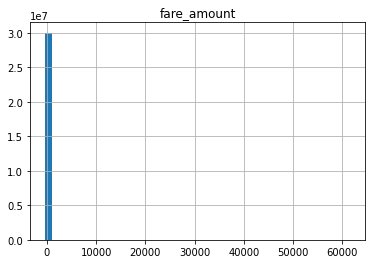

In [19]:
df_train.hist(column='fare_amount',bins=50)

Observamos una gran concentración de datos para los valores más pequeños de fare_amount. Acercamos la gráfica para poder distinguir mejor estos valores.

(-10.0, 400.0)

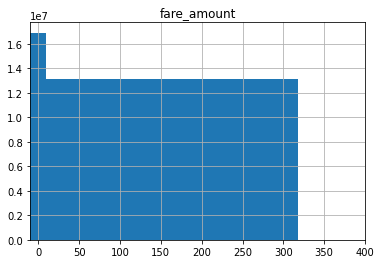

In [20]:
df_train.hist(column='fare_amount',bins=200)

plot.xlim(-10,400)

Podemos observar que los valores más significativos se encuentran entre 0 y 100 

Obervamos que el el minimo del monto de tarifa es negativo, veamos cuantos montos de tarifa menores o iguales a cero y mayores de 100 tenemos: 

In [21]:
len(df_train[df_train['fare_amount'] <= 0].index)

2063

In [22]:
len(df_train[df_train['fare_amount'] > 100].index)

11384

In [23]:
df_train[df_train['fare_amount'] <= 0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.9,2010-03-09 23:37:10 UTC,-73.789452,40.643497,-73.788666,40.641953,1
2486,-2.5,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
10002,0.0,2010-02-15 14:26:01 UTC,-73.987114,40.738808,-74.005913,40.713959,1
13032,-3.0,2013-08-30 08:57:10 UTC,-73.995064,40.740753,-73.995888,40.741356,4
27891,0.0,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1
...,...,...,...,...,...,...,...
29920970,-2.9,2010-03-26 20:39:10 UTC,-73.983231,40.777557,-73.982231,40.776123,4
29926640,0.0,2015-03-15 13:25:28 UTC,-73.973946,40.801060,0.000000,0.000000,1
29956234,-4.1,2010-02-24 04:40:10 UTC,-74.005692,40.726345,-74.006035,40.725853,4
29964098,-52.0,2015-01-04 12:50:33 UTC,-73.988319,40.727798,-73.991074,40.723991,1


Solo queremos los datos donde el monto de la tarifa sea mayor que cero y menor que 100:

In [24]:
df_train = df_train[df_train['fare_amount'] > 0]

In [25]:
df_train = df_train[df_train['fare_amount'] <= 100]

In [26]:
df_train[['fare_amount']].describe()

,fare_amount
count,2.998635e+07
mean,1.000329e+01
std,9.022541e+00
min,1.000000e-02
25%,6.000000e+00
50%,8.500000e+00
75%,1.250000e+01
max,1.000000e+02


# Analizando la longitud y latidud

El rango de la latidud es de -90 hasta 90 grados, mientras que el grado de la longitud es de -180 hasta los 180 grados.



In [27]:
df_train = df_train[(df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180)]

In [28]:
df_train = df_train[(df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90)]

In [29]:
df_train = df_train[(df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180)]

In [30]:
df_train = df_train[(df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)]

Analizaremos gráficamente pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude y reduciremos la data de acuerdo a la mayor concentración de data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d3900a50>]],
      dtype=object)

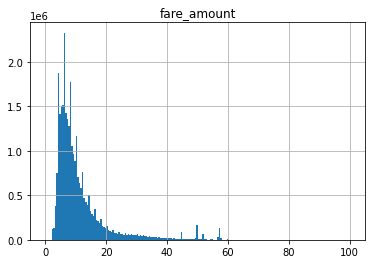

In [31]:
df_train.hist(column='fare_amount',bins=200)

Acercamos para un mejor análisis

(-76.0, -73.0)

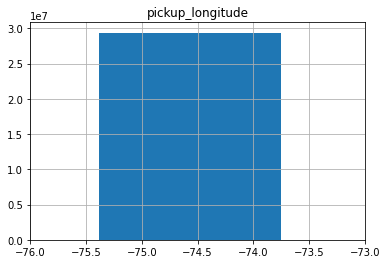

In [32]:
df_train.hist(column='pickup_longitude',bins=200)
#plot.ylim(0,1000)
plot.xlim(-76,-73)

In [33]:
len(df_train[df_train['pickup_longitude'] < -75].index)

2789

In [34]:
len(df_train[df_train['pickup_longitude'] >= -73.3].index)

601345

Observamos que la contración de datos se encuentras entre -75 y -73.

In [35]:
df_train = df_train[(df_train['pickup_longitude'] > -75) & (df_train['pickup_longitude'] <= -73.3)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d346ab10>]],
      dtype=object)

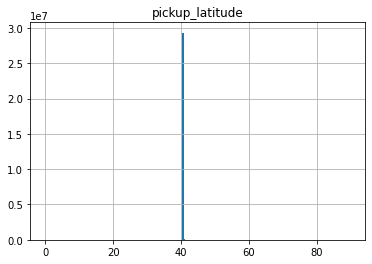

In [36]:
df_train.hist(column='pickup_latitude',bins=200)

Acercaremos para analizar mejor el gráfico.

(38.0, 45.0)

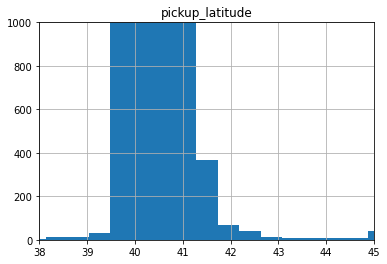

In [37]:
df_train.hist(column='pickup_latitude',bins=200)
plot.ylim(0,1000)
plot.xlim(38,45)

In [38]:
len(df_train[df_train['pickup_latitude'] < 39.5].index)

928

In [39]:
len(df_train[df_train['pickup_latitude'] > 42].index)

214

In [40]:
df_train = df_train[(df_train['pickup_latitude'] >=39 ) & (df_train['pickup_latitude'] <=42)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d3a9bb50>]],
      dtype=object)

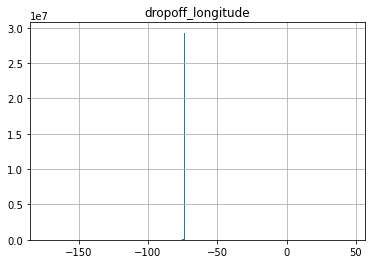

In [41]:
df_train.hist(column='dropoff_longitude',bins=200)

Acercamos para analizar mejor el gráfico

(-74.5, -72.5)

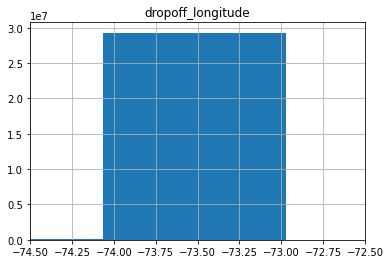

In [42]:
df_train.hist(column='dropoff_longitude',bins=200)

plot.xlim(-74.5,-72.5)

In [43]:
len(df_train[df_train['dropoff_longitude'] < -74.5].index)

2549

In [44]:
len(df_train[df_train['dropoff_longitude'] > -72.5].index)

27443

In [45]:
df_train = df_train[(df_train['dropoff_longitude'] >=-74.5 ) & (df_train['dropoff_longitude'] <=-72.5)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d39cef90>]],
      dtype=object)

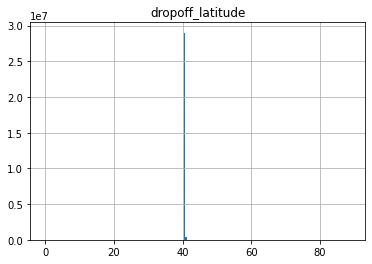

In [46]:
df_train.hist(column='dropoff_latitude',bins=200)

(40.0, 42.0)

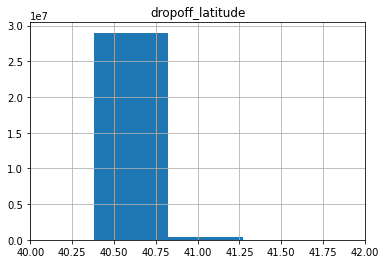

In [47]:
df_train.hist(column='dropoff_latitude',bins=200)
plot.xlim(40,42)

In [48]:
len(df_train[df_train['dropoff_latitude'] < 40.5].index)

5702

In [49]:
len(df_train[df_train['dropoff_latitude'] > 41].index)

3316

In [50]:
df_train = df_train[(df_train['dropoff_latitude'] >=40.5 ) & (df_train['dropoff_latitude'] <=41)]

In [51]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.934061e+07,2.934061e+07,2.934061e+07,2.934061e+07,2.934061e+07,2.934061e+07
mean,1.008736e+01,-7.319152e+01,3.659576e+01,-7.319152e+01,3.659576e+01,1.685619e+00
std,8.957521e+00,7.562152e-01,4.277602e+00,7.562228e-01,4.277602e+00,1.313531e+00
min,1.000000e-02,-7.499062e+01,3.900730e+01,-7.450000e+01,4.050003e+01,0.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073656e+01,-7.399158e+01,4.073558e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398061e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076752e+01,-7.396539e+01,4.076838e+01,2.000000e+00
max,1.000000e+02,-7.330000e+01,4.200000e+01,-7.251667e+01,4.099998e+01,2.080000e+02


In [52]:
len(df_train.index)

29340606

In [53]:
def distancia(df):
  # Radio medio de la tierra en Km
  R = 6371.0
  # Conversion a radianes
  lt1 = np.radians(df.pickup_latitude)
  lg1 = np.radians(df.pickup_longitude)
  lt2 = np.radians(df.dropoff_latitude)
  lg2 = np.radians(df.dropoff_longitude)
  # Defirencia entre latitudes y longitudes
  dlt = lt2 - lt1
  dlg = lg2 - lg1
  # Haversine
  hav = np.sin(dlt / 2)**2 + np.cos(lt1) * np.cos(lt2) * np.sin(dlg / 2)**2
  c = 2 * np.arctan2(np.sqrt(hav), np.sqrt(1-hav))
  d = R * c
  return d

In [54]:
df_train['distancia'] = distancia(df_train)

In [55]:
df_train = df_train.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

Usando un tipo de dato eficiente para distancia.


In [56]:
df_train["distancia"] = pd.to_numeric(df_train["distancia"], downcast="float")

In [57]:
df_train[['distancia']].describe()

,distancia
count,2.934061e+07
mean,2.938675e+00
std,3.513842e+00
min,0.000000e+00
25%,1.253772e+00
50%,2.152711e+00
75%,3.906809e+00
max,1.970339e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d31bd750>]],
      dtype=object)

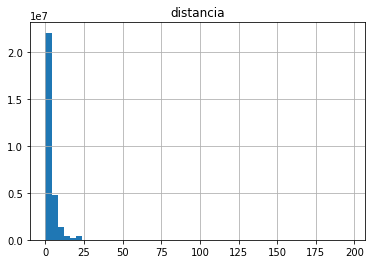

In [58]:
df_train.hist(column='distancia',bins=50)

(-5.0, 35.0)

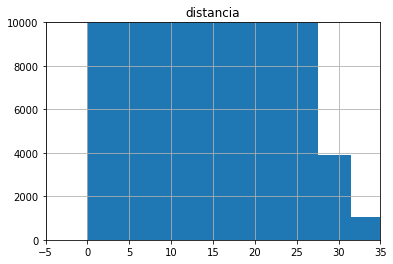

In [59]:
df_train.hist(column='distancia',bins=50)
plot.ylim(0,10000)
plot.xlim(-5,35)

In [60]:
len(df_train[df_train['distancia'] < 0].index)

0

In [61]:
len(df_train[df_train['distancia'] > 28].index)

6948

In [62]:
df_train = df_train[(df_train['distancia'] >0 ) & (df_train['distancia'] <28)]

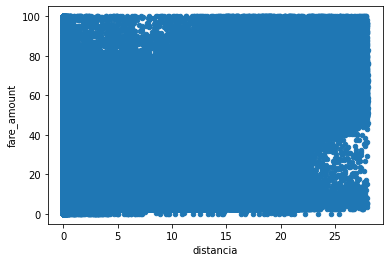

In [63]:
df_train.plot.scatter(x='distancia',
                               y='fare_amount')

# Analizando pickup_datetime

In [64]:
df_train['pickup_datetime']

0           2009-06-15 17:26:21 UTC
1           2010-01-05 16:52:16 UTC
2           2011-08-18 00:35:00 UTC
3           2012-04-21 04:30:42 UTC
4           2010-03-09 07:51:00 UTC
                     ...           
29999995    2010-12-31 16:08:33 UTC
29999996    2011-02-15 15:53:21 UTC
29999997    2011-12-17 20:28:07 UTC
29999998    2013-03-26 09:07:00 UTC
29999999    2011-11-22 18:10:44 UTC
Name: pickup_datetime, Length: 29026472, dtype: object

In [65]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.replace(" UTC", "")

In [66]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

Usando tipos de dato eficientes para "año" , "mes" , "dia" , "hora" , para una reducción de memoria.

In [67]:
df_train['año'] = df_train.pickup_datetime.dt.year
df_train["año"] = pd.to_numeric(df_train["año"], downcast="unsigned")

df_train['mes'] = df_train.pickup_datetime.dt.month
df_train["mes"] = pd.to_numeric(df_train["mes"], downcast="unsigned")

In [68]:
df_train['dia'] = df_train.pickup_datetime.dt.day
df_train["dia"] = pd.to_numeric(df_train["dia"], downcast="unsigned")

df_train['hora'] = df_train.pickup_datetime.dt.hour
df_train["hora"] = pd.to_numeric(df_train["hora"], downcast="unsigned")

In [69]:
df_train = df_train.drop(columns=['pickup_datetime'])

In [70]:
df_train.head()

,fare_amount,passenger_count,distancia,año,mes,dia,hora
0,4.5,1,1.031069,2009,6,15,17
1,16.9,1,8.449763,2010,1,5,16
2,5.7,2,1.389644,2011,8,18,0
3,7.7,1,2.799485,2012,4,21,4
4,5.3,1,1.998886,2010,3,9,7


# Analizando Cantidad de pasajeros

In [71]:
df_train[['passenger_count']].describe()

,passenger_count
count,2.902647e+07
mean,1.685686e+00
std,1.312978e+00
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.080000e+02


Analizamos gráficamente la columna passenger_count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d3b93a50>]],
      dtype=object)

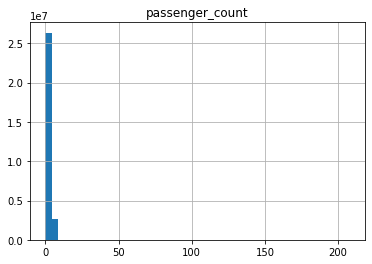

In [72]:
df_train.hist(column='passenger_count',bins=50)

Observamos una concentración de datos en los primeros valores positivos.

(0.0, 12.0)

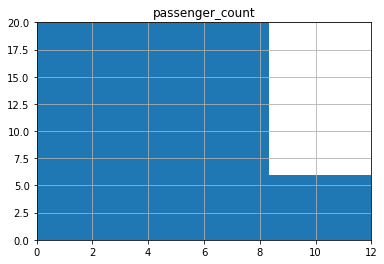

In [73]:
df_train.hist(column='passenger_count',bins=50)
plot.ylim(0,20)
plot.xlim(0,12)

Eliminamos la data que contenga cantidad de pasajeros mayor o igual a 8

In [74]:
df_train = df_train[0 < df_train['passenger_count']]

In [75]:
df_train = df_train[df_train['passenger_count'] < 8]

In [76]:
df_train[['passenger_count']].describe()

,passenger_count
count,2.892315e+07
mean,1.691650e+00
std,1.307289e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,7.000000e+00


Graficamos passenger_count después de reducir la data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1d3445c10>]],
      dtype=object)

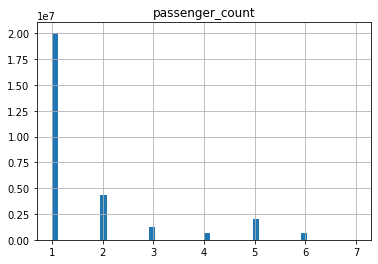

In [77]:
df_train.hist(column='passenger_count',bins=50)

In [78]:
len(df_train.index)

28923146

**Uso total de la memoria al final**

In [79]:
memoria_final2 = df_train.memory_usage(deep=True).sum()
print(f"{memoria_final2/1e9:0.2f}GB")

0.64GB


# Entrenamieto

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

predictors = ['passenger_count', 'distancia', 'año', 'mes', 'dia', 'hora']
salida = 'fare_amount'

X = df_train[predictors]
y = df_train[salida]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)

rf = RandomForestRegressor(n_estimators=500,
                            oob_score = True,
                            random_state=1,
                            max_depth=8)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
from joblib import dump, load
dump(rf, 'Modelo.joblib')

['Modelo.joblib']

In [ ]:
clf = load('/content/drive/MyDrive/Modelo.joblib')
from sklearn.metrics import mean_squared_error

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Conjunto de entrenamiento")
print(mean_squared_error(y_train, y_pred_train))
print("Conjunto de pruebas")
print(mean_squared_error(y_test, y_pred_test))